# F-Regularization Experiment (Phase 5)

**Goal**: Test causal hypothesis - Does minimizing geDIG F during training improve performance?

- Baseline: standard CrossEntropy fine-tuning
- Treatment: L_total = L_CE + α * F_mean
- α sweep: [0, 0.001, 0.01, 0.1, 1.0] × 3 seeds

In [1]:
# Check GPU
!nvidia-smi

Wed Dec 17 04:56:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies
!pip install -q transformers datasets accelerate

In [3]:
# Inline the training script (to avoid file upload issues)
TRAIN_SCRIPT = '''
#!/usr/bin/env python3
"""
F-Regularized Training Experiment

Tests the causal hypothesis: Does minimizing geDIG F during training improve performance?
"""

from __future__ import annotations

import argparse
import json
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.modeling_outputs import SequenceClassifierOutput


@dataclass
class DifferentiableGeDIG:
    """Computes geDIG F in a differentiable manner."""
    lambda_param: float = 1.0
    gamma: float = 0.5
    temperature: float = 0.1
    percentile: float = 0.9
    max_path_length: int = 4

    def compute_F(self, attention: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        batch_size, num_heads, seq_len, _ = attention.shape
        if attention_mask is not None:
            mask_2d = attention_mask.unsqueeze(1).unsqueeze(2) * attention_mask.unsqueeze(1).unsqueeze(3)
            attention = attention * mask_2d.float()
        delta_epc = self._compute_soft_density(attention)
        delta_h = self._compute_entropy(attention, attention_mask)
        delta_sp = self._compute_soft_path_efficiency(attention, attention_mask)
        F_values = delta_epc - self.lambda_param * (delta_h + self.gamma * delta_sp)
        return {"F": F_values, "F_mean": F_values.mean(), "delta_epc": delta_epc, "delta_h": delta_h, "delta_sp": delta_sp}

    def _compute_soft_density(self, attention: torch.Tensor) -> torch.Tensor:
        batch_size, num_heads, seq_len, _ = attention.shape
        attn_flat = attention.view(batch_size, num_heads, -1)
        k = int(self.percentile * seq_len * seq_len)
        threshold = torch.kthvalue(attn_flat, k, dim=-1).values.unsqueeze(-1).unsqueeze(-1)
        edge_probs = torch.sigmoid((attention - threshold) / self.temperature)
        return edge_probs.sum(dim=(-2, -1)) / (seq_len * seq_len)

    def _compute_entropy(self, attention: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, num_heads, seq_len, _ = attention.shape
        attn_flat = attention.view(batch_size, num_heads, -1)
        attn_norm = attn_flat / (attn_flat.sum(dim=-1, keepdim=True) + 1e-10)
        entropy = -(attn_norm * torch.log(attn_norm + 1e-10)).sum(dim=-1)
        if attention_mask is not None:
            valid_count = attention_mask.sum(dim=-1).float()
            max_entropy = torch.log(valid_count * valid_count + 1e-10).unsqueeze(1)
        else:
            max_entropy = math.log(seq_len * seq_len)
        return entropy / (max_entropy + 1e-10)

    def _compute_soft_path_efficiency(self, attention: torch.Tensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, num_heads, seq_len, _ = attention.shape
        attn_flat = attention.view(batch_size, num_heads, -1)
        k = int(self.percentile * seq_len * seq_len)
        threshold = torch.kthvalue(attn_flat, k, dim=-1).values.unsqueeze(-1).unsqueeze(-1)
        adj = torch.sigmoid((attention - threshold) / self.temperature)
        eye = torch.eye(seq_len, device=attention.device).unsqueeze(0).unsqueeze(0)
        adj = adj + eye
        path_efficiency = torch.zeros(batch_size, num_heads, device=attention.device)
        adj_power = adj.clone()
        for path_len in range(1, self.max_path_length + 1):
            if path_len > 1:
                adj_power = torch.clamp(torch.matmul(adj_power, adj), 0, 1)
            path_efficiency = path_efficiency + (1.0 / path_len) * (adj_power > 0.5).float().mean(dim=(-2, -1))
        return path_efficiency / self.max_path_length


class FRegularizedModel(nn.Module):
    """Wrapper that adds geDIG F regularization to the loss."""
    def __init__(self, base_model: nn.Module, alpha: float = 0.1, gedig_config: Optional[Dict[str, Any]] = None):
        super().__init__()
        self.base_model = base_model
        self.alpha = alpha
        self.gedig = DifferentiableGeDIG(**(gedig_config or {}))
        self._last_gedig_metrics: Optional[Dict[str, float]] = None

    def forward(self, input_ids: torch.Tensor, attention_mask: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None, **kwargs) -> SequenceClassifierOutput:
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, output_attentions=True, **kwargs)
        if labels is not None and self.alpha > 0:
            f_values = [self.gedig.compute_F(layer_attn, attention_mask)["F_mean"] for layer_attn in outputs.attentions]
            f_mean = torch.stack(f_values).mean()
            total_loss = outputs.loss + self.alpha * f_mean
            self._last_gedig_metrics = {"f_mean": f_mean.item(), "ce_loss": outputs.loss.item(), "total_loss": total_loss.item()}
            return SequenceClassifierOutput(loss=total_loss, logits=outputs.logits, hidden_states=None, attentions=None)
        return SequenceClassifierOutput(loss=outputs.loss, logits=outputs.logits, hidden_states=None, attentions=None)


class FRegularizedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        loss = outputs.loss
        if hasattr(model, "_last_gedig_metrics") and model._last_gedig_metrics:
            self.log(model._last_gedig_metrics)
        return (loss, outputs) if return_outputs else loss


def compute_final_gedig_metrics(model, eval_dataset, tokenizer, data_collator):
    from torch.utils.data import DataLoader
    device = next(model.parameters()).device
    model.eval()
    dataloader = DataLoader(eval_dataset, batch_size=32, collate_fn=data_collator)
    gedig = DifferentiableGeDIG()
    all_f, all_epc, all_h, all_sp = [], [], [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            base = model.base_model if hasattr(model, "base_model") else model
            outputs = base(input_ids=batch["input_ids"], attention_mask=batch.get("attention_mask"), output_attentions=True)
            for layer_attn in outputs.attentions:
                metrics = gedig.compute_F(layer_attn, batch.get("attention_mask"))
                all_f.append(metrics["F"].mean().item())
                all_epc.append(metrics["delta_epc"].mean().item())
                all_h.append(metrics["delta_h"].mean().item())
                all_sp.append(metrics["delta_sp"].mean().item())
    return {"f_mean": np.mean(all_f), "f_std": np.std(all_f), "delta_epc_mean": np.mean(all_epc), "delta_h_mean": np.mean(all_h), "delta_sp_mean": np.mean(all_sp)}


def run_experiment(alpha, model_name="distilbert-base-uncased", train_samples=1000, eval_samples=500, epochs=3, batch_size=16, learning_rate=2e-5, seed=42, output_dir=None):
    set_seed(seed)
    if output_dir is None:
        output_dir = Path(f"results/f_reg/alpha_{alpha}_seed_{seed}")
    output_dir.mkdir(parents=True, exist_ok=True)
    print(f"\\n{\"="*60}\\nRunning: alpha={alpha}, seed={seed}\\n{\"="*60}")
    
    ds_train = load_dataset("glue", "sst2", split=f"train[:{train_samples}]")
    ds_eval = load_dataset("glue", "sst2", split=f"validation[:{eval_samples}]")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenize_fn = lambda ex: tokenizer(ex["sentence"], truncation=True, max_length=128)
    train_ds = ds_train.map(tokenize_fn, batched=True)
    eval_ds = ds_eval.map(tokenize_fn, batched=True)
    cols = [c for c in train_ds.column_names if c not in ("input_ids", "attention_mask", "label")]
    train_ds = train_ds.remove_columns(cols).with_format("torch")
    eval_ds = eval_ds.remove_columns(cols).with_format("torch")
    
    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model = FRegularizedModel(base_model, alpha=alpha) if alpha > 0 else base_model
    
    training_args = TrainingArguments(
        output_dir=str(output_dir), eval_strategy="steps", eval_steps=50, logging_steps=10,
        save_strategy="epoch", per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs, learning_rate=learning_rate, weight_decay=0.01, report_to=[], seed=seed,
    )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = FRegularizedTrainer(
        model=model, args=training_args, train_dataset=train_ds, eval_dataset=eval_ds,
        tokenizer=tokenizer, data_collator=data_collator,
        compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()},
    )
    train_result = trainer.train()
    eval_result = trainer.evaluate()
    final_f = compute_final_gedig_metrics(model, eval_ds, tokenizer, data_collator)
    
    result = {"alpha": alpha, "seed": seed, "final_accuracy": eval_result.get("eval_accuracy"),
              "final_loss": eval_result.get("eval_loss"), "train_runtime": train_result.metrics.get("train_runtime"), "final_gedig": final_f}
    (output_dir / "result.json").write_text(json.dumps(result, indent=2))
    print(f"Result: acc={result[\"final_accuracy\"]:.4f}, F={final_f.get(\"f_mean\", \"N/A\")}")
    return result


def run_alpha_sweep(alphas=[0.0, 0.001, 0.01, 0.1, 1.0], seeds=[42, 123, 456], **kwargs):
    results = []
    for alpha in alphas:
        for seed in seeds:
            results.append(run_experiment(alpha=alpha, seed=seed, **kwargs))
    return results
'''

# Write to file
with open('train_f_reg.py', 'w') as f:
    f.write(TRAIN_SCRIPT)
print('Script written to train_f_reg.py')

Script written to train_f_reg.py


In [4]:
# Import and run
import json
import numpy as np
from pathlib import Path

exec(open('train_f_reg.py').read())

# Configuration
ALPHAS = [0.0, 0.001, 0.01, 0.1, 1.0]
SEEDS = [42, 123, 456]
TRAIN_SAMPLES = 2000  # Increase for better results
EVAL_SAMPLES = 500
EPOCHS = 3
BATCH_SIZE = 16

print(f"Running {len(ALPHAS)} alphas x {len(SEEDS)} seeds = {len(ALPHAS)*len(SEEDS)} experiments")

Running 5 alphas x 3 seeds = 15 experiments


In [5]:
# Run full sweep
results = run_alpha_sweep(
    alphas=ALPHAS,
    seeds=SEEDS,
    train_samples=TRAIN_SAMPLES,
    eval_samples=EVAL_SAMPLES,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

# Save all results
Path('results').mkdir(exist_ok=True)
with open('results/all_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\nSaved {len(results)} results to results/all_results.json")


Running: alpha=0.0, seed=42


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.577500,0.545466,0.798000
100,0.377300,0.378958,0.830000
150,0.232600,0.368626,0.838000
200,0.326400,0.364370,0.852000
250,0.217500,0.372274,0.852000
300,0.145500,0.377634,0.868000
350,0.096800,0.388014,0.862000


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Result: acc=0.8640, F=-0.44785186524192494

Running: alpha=0.0, seed=123


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.516900,0.503266,0.770000
100,0.366500,0.424737,0.802000
150,0.262300,0.372074,0.842000
200,0.253100,0.398451,0.846000
250,0.246700,0.366938,0.860000
300,0.104000,0.439996,0.846000
350,0.196000,0.422331,0.854000


Result: acc=0.8540, F=-0.45181260506312054

Running: alpha=0.0, seed=456


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.422100,0.418170,0.818000
100,0.333400,0.358784,0.854000
150,0.287500,0.398614,0.836000
200,0.197100,0.361667,0.868000
250,0.201700,0.392360,0.852000
300,0.153300,0.409865,0.850000
350,0.097200,0.391545,0.864000


Result: acc=0.8620, F=-0.44339135382324457

Running: alpha=0.001, seed=42


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.558600,0.535212,0.796000
100,0.396400,0.393372,0.828000
150,0.230100,0.364045,0.842000
200,0.315500,0.378382,0.842000
250,0.229000,0.360645,0.852000
300,0.153400,0.361870,0.868000
350,0.114700,0.373612,0.866000


Result: acc=0.8660, F=-0.4458892218147715

Running: alpha=0.001, seed=123


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.507000,0.518547,0.746000
100,0.343600,0.389568,0.814000
150,0.218300,0.360066,0.868000
200,0.319500,0.358209,0.868000
250,0.234800,0.349397,0.862000
300,0.085600,0.433015,0.844000
350,0.242500,0.410452,0.848000


Result: acc=0.8580, F=-0.45125190696368617

Running: alpha=0.001, seed=456


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.412100,0.404022,0.828000
100,0.337400,0.366152,0.846000
150,0.261100,0.376199,0.846000
200,0.212200,0.370426,0.862000
250,0.248300,0.408587,0.864000
300,0.124400,0.422144,0.848000
350,0.102500,0.399256,0.870000


Result: acc=0.8660, F=-0.44840566348284483

Running: alpha=0.01, seed=42


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.554100,0.531372,0.798000
100,0.394400,0.389227,0.830000
150,0.224700,0.361974,0.840000
200,0.313400,0.373505,0.846000
250,0.226000,0.356583,0.856000
300,0.147400,0.360481,0.868000
350,0.108000,0.371696,0.866000


Result: acc=0.8660, F=-0.452173908551534

Running: alpha=0.01, seed=123


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.498700,0.510292,0.750000
100,0.342700,0.386316,0.818000
150,0.212300,0.353586,0.862000
200,0.321200,0.350987,0.864000
250,0.229400,0.344345,0.868000
300,0.087400,0.430424,0.846000
350,0.237400,0.408057,0.850000


Result: acc=0.8560, F=-0.45585237505535287

Running: alpha=0.01, seed=456


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.409000,0.402564,0.824000
100,0.336100,0.364098,0.852000
150,0.255200,0.372581,0.846000
200,0.206900,0.366943,0.862000
250,0.245300,0.405006,0.864000
300,0.118600,0.418019,0.846000
350,0.098400,0.393963,0.872000


Result: acc=0.8660, F=-0.4535005052263538

Running: alpha=0.1, seed=42


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.542500,0.513908,0.786000
100,0.335700,0.347785,0.818000
150,0.183700,0.339933,0.830000
200,0.273900,0.340314,0.824000
250,0.180300,0.311160,0.858000
300,0.104900,0.329475,0.850000
350,0.061400,0.344839,0.848000


Result: acc=0.8500, F=-0.5017823604866862

Running: alpha=0.1, seed=123


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.457800,0.478038,0.740000
100,0.302600,0.346093,0.816000
150,0.181500,0.328272,0.860000
200,0.291800,0.308125,0.856000
250,0.217600,0.301483,0.858000
300,0.074900,0.397647,0.830000
350,0.192700,0.376765,0.850000


Result: acc=0.8580, F=-0.49635885438571375

Running: alpha=0.1, seed=456


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.373200,0.377603,0.810000
100,0.300900,0.338059,0.830000
150,0.213900,0.333258,0.846000
200,0.158500,0.329822,0.864000
250,0.185300,0.354654,0.848000
300,0.082400,0.360931,0.856000
350,0.072300,0.352891,0.868000


Result: acc=0.8700, F=-0.490809961532553

Running: alpha=1.0, seed=42


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.102900,0.065929,0.530000
100,0.065900,0.022341,0.564000
150,-0.084600,-0.120314,0.744000
200,-0.188600,-0.174303,0.782000
250,-0.163100,-0.155346,0.788000
300,-0.285700,-0.145841,0.778000
350,-0.305300,-0.144516,0.772000


Result: acc=0.7740, F=-0.6198077493657669

Running: alpha=1.0, seed=123


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.121400,0.100690,0.470000
100,-0.002700,-0.014655,0.684000
150,-0.163100,-0.149524,0.786000
200,-0.067000,-0.143757,0.788000
250,-0.224900,-0.180082,0.804000
300,-0.369200,-0.156300,0.802000
350,-0.278800,-0.150404,0.816000


Result: acc=0.8120, F=-0.5992669990907112

Running: alpha=1.0, seed=456


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<string>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FRegularizedTrainer.__init__`. Use `processing_class` instead.


Step,Training Loss,Validation Loss,Accuracy
50,0.106400,0.055766,0.548000
100,0.053700,-0.012352,0.730000
150,-0.058600,-0.069245,0.712000
200,-0.217900,-0.157411,0.778000
250,-0.216700,-0.166748,0.774000
300,-0.284400,-0.149590,0.780000
350,-0.346200,-0.142540,0.780000


Result: acc=0.7820, F=-0.6165243970851103

Saved 15 results to results/all_results.json


In [6]:
# Analyze results
import pandas as pd

df = pd.DataFrame(results)

# Summary by alpha
summary = df.groupby('alpha').agg({
    'final_accuracy': ['mean', 'std'],
    'final_loss': ['mean', 'std'],
}).round(4)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(summary)

# Best alpha
best_idx = df.groupby('alpha')['final_accuracy'].mean().idxmax()
baseline_acc = df[df['alpha']==0]['final_accuracy'].mean()
best_acc = df[df['alpha']==best_idx]['final_accuracy'].mean()

print(f"\nBaseline (α=0): {baseline_acc:.4f}")
print(f"Best (α={best_idx}): {best_acc:.4f}")
print(f"Improvement: {best_acc - baseline_acc:+.4f}")


RESULTS SUMMARY
      final_accuracy         final_loss        
                mean     std       mean     std
alpha                                          
0.000         0.8600  0.0053     0.4033  0.0178
0.001         0.8633  0.0046     0.3925  0.0191
0.010         0.8627  0.0058     0.3884  0.0171
0.100         0.8593  0.0101     0.3534  0.0070
1.000         0.7893  0.0200    -0.1436  0.0042

Baseline (α=0): 0.8600
Best (α=0.001): 0.8633
Improvement: +0.0033


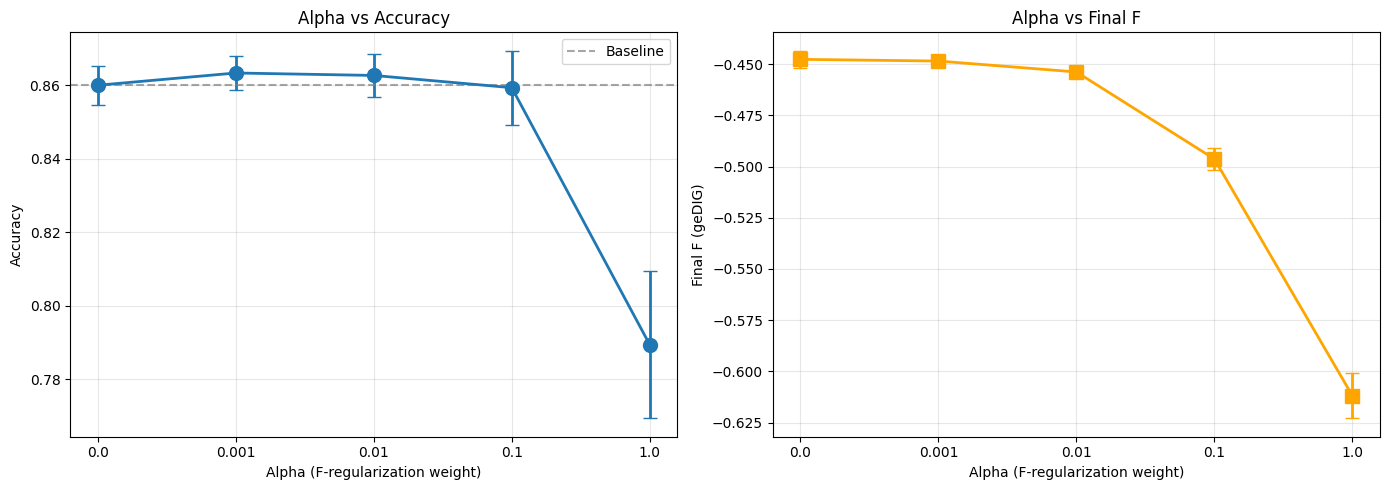

Saved: results/fig_f_reg_summary.png


In [7]:
# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Alpha vs Accuracy
grouped = df.groupby('alpha')['final_accuracy'].agg(['mean', 'std']).reset_index()
ax1 = axes[0]
ax1.errorbar(range(len(grouped)), grouped['mean'], yerr=grouped['std'], 
             marker='o', markersize=10, linewidth=2, capsize=5)
ax1.set_xticks(range(len(grouped)))
ax1.set_xticklabels([f"{a}" for a in grouped['alpha']])
ax1.set_xlabel('Alpha (F-regularization weight)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Alpha vs Accuracy')
ax1.axhline(y=baseline_acc, color='gray', linestyle='--', alpha=0.7, label='Baseline')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Alpha vs Final F
f_data = []
for r in results:
    if r.get('final_gedig'):
        f_data.append({'alpha': r['alpha'], 'f_mean': r['final_gedig']['f_mean']})
f_df = pd.DataFrame(f_data)
f_grouped = f_df.groupby('alpha')['f_mean'].agg(['mean', 'std']).reset_index()

ax2 = axes[1]
ax2.errorbar(range(len(f_grouped)), f_grouped['mean'], yerr=f_grouped['std'],
             marker='s', markersize=10, linewidth=2, capsize=5, color='orange')
ax2.set_xticks(range(len(f_grouped)))
ax2.set_xticklabels([f"{a}" for a in f_grouped['alpha']])
ax2.set_xlabel('Alpha (F-regularization weight)')
ax2.set_ylabel('Final F (geDIG)')
ax2.set_title('Alpha vs Final F')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fig_f_reg_summary.png', dpi=150)
plt.show()
print("Saved: results/fig_f_reg_summary.png")

In [9]:
# Download results
from google.colab import files

# Zip results
!zip -r f_reg_results.zip results/
files.download('f_reg_results.zip')

  adding: results/ (stored 0%)
  adding: results/f_reg/ (stored 0%)
  adding: results/f_reg/alpha_0.01_seed_456/ (stored 0%)
  adding: results/f_reg/alpha_0.01_seed_456/result.json (deflated 41%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/ (stored 0%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/model.safetensors (deflated 8%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/training_args.bin (deflated 53%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/special_tokens_map.json (deflated 42%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/vocab.txt (deflated 53%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/tokenizer_config.json (deflated 75%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/rng_state.pth (deflated 26%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/trainer_state.json (deflated 77%)
  adding: results/f_reg/alpha_0.01_seed_456/checkpoint-125/optimizer.pt (deflated 36%)
  a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Interpretation

**Success criteria**:
1. α > 0 outperforms baseline (α=0) → F-regularization helps
2. Optimal α exists (not monotonic) → there's a sweet spot
3. Final F is lower for regularized models → F is being minimized

**If successful**: geDIG F is not just correlated with good attention, but causally contributes to it.